# Selective Summarization - dev

In [123]:
# path to anaconda : C:\ProgramData\Anaconda3

from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import time
import math
import re
import json
import random
import itertools


from termcolor import colored

In [124]:
import sys
sys.version

'3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]'

In [125]:
# for manipulating dataframes, arrays, containers...
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd
import unidecode
from unidecode import unidecode

# equivalent of numpy for very large arrays (such as a database of pretrained word vectors)
# optimized for SQL-like operations, not for math computations
# see https://bcolz.readthedocs.io/en/latest/intro.html

# installer avec la commande : conda install bcolz
import bcolz

import pickle

In [126]:
# for viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker #, FuncFormatter
%matplotlib inline

import seaborn as sns

In [127]:
# for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

In [128]:
# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

print(torch.__version__)

use_cuda = False
print(torch.cuda.is_available())

import warnings
warnings.filterwarnings("ignore")

0.4.1
False


In [129]:
# for NLP
import gensim
from gensim.models import KeyedVectors

import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer

from textblob import TextBlob

In [130]:
import warnings
warnings.filterwarnings('ignore')

In [131]:
path_to_rep = 'C:\\Users\jbaujogue\Desktop\Scripts'

# 1 Préparation des données

## 1.1 Import des données

Import des données, issues de https://asrs.arc.nasa.gov/search/database.html

In [234]:
lim = 250
df_ASRS = pd.read_csv(path_to_rep + '\data\Tickets_ASRS\\tickets_ASRS_shuffle.csv', sep=',', header=0)
df_ASRS = df_ASRS.ix[:lim,1:]
print(df_ASRS.shape)
df_ASRS.head()

(251, 10)


,ACN,Description,Résumé,Composant_concerné,Nature_primaire_problème,Type_problème,Description_problème,Détection,Facteur_humain,Facteurs_impliqués
0,1372405,Briefly encountered severe turbulence at FL340...,A319 Captain reported encountering severe turb...,NaN,Weather,NaN,Deviation - Altitude Excursion From Assigned A...,Person Flight Crew,Situational Awareness,Weather; Human Factors
1,1502548,During climb thru approximately 15000 ft Capta...,B737 Captain reported smoke in the cabin durin...,NaN,Aircraft,NaN,Aircraft Equipment Problem Less Severe; Flight...,Person Flight Attendant; Person Flight Crew,Troubleshooting; Time Pressure; Distraction; C...,Aircraft
2,1340662,The problem was a loss of directional control ...,A PA-28 pilot reported losing directional cont...,NaN,Human Factors,NaN,Ground Event / Encounter Loss Of Aircraft Cont...,Person Flight Crew,Situational Awareness; Training / Qualification,Human Factors; Weather
3,1226984,I departed for my second break-in flight on a ...,BE35 pilot reports flying a new engine break i...,Reciprocating Engine Assembly,Ambiguous,Malfunctioning,Aircraft Equipment Problem Less Severe; Inflig...,Person Flight Crew,Distraction; Situational Awareness,Human Factors; Aircraft
4,1251840,Takeoff and climb were normal at this point. W...,Medium Large Transport flight crew experiences...,Turbine Engine,Aircraft,Failed,Aircraft Equipment Problem Critical; Flight De...,Person Flight Crew,NaN,Aircraft


In [235]:
def Head2count(df) :
    Head = df.columns.values
    Head2count = {}
    for i, title in enumerate(Head) :
        Head2count[title] = i
    return Head2count

In [236]:
Head2count(df_ASRS)

{'ACN': 0,
 'Description': 1,
 'Résumé': 2,
 'Composant_concerné': 3,
 'Nature_primaire_problème': 4,
 'Type_problème': 5,
 'Description_problème': 6,
 'Détection': 7,
 'Facteur_humain': 8,
 'Facteurs_impliqués': 9}

## 1.2 Segmentation et formattage de texte

In [237]:
# --------------------------- Normalisation -------------------------------
def unicodeToAscii(s):
    """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    '''Remove rare symbols from a string'''
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9\>\=]+", r" ", s)  # 'r' before a string is for 'raw' # ?&\%\_\- removed # set('''.,:;()*#&-_%!?/\'")''')
    return s



# -------------------- segmentation de texte -------------------------------------
def segmentText(text, stopwords = []) :
    '''Segments a string into a list of sentences, each consisting of a list of words as strings'''
    new_text = text.replace('   ', '.').split('.')
    new_text = [normalizeString(line) for line in new_text]
    new_text = [[word for word in line.split() if word not in stopwords] for line in new_text]
    new_text = [line for line in new_text if line!= []]
    return new_text

    
def segmentTextNltk(text, stopwords = []) :
    '''Segments a string into a list of sentences, each consisting of a list of words as strings'''
    #text = clean_sentence_punct(text.lower())
    text = text.lower()
    new_text = sent_tokenize(text) 
    new_text = [word_tokenize(line) for line in new_text]
    new_text = [[word for word in line if word not in stopwords] for line in new_text]
    new_text = [line for line in new_text if line!= []]
    return new_text
    

stopwords4resume = nltk.corpus.stopwords.words('english')


def formatTextASRS(df) :
    dfe = df.copy()
    for i in range(len(dfe)) :
        # ------------------------------------------------------------ formattage des textes
        # formattage des descriptions
        text = dfe.ix[i, 1]
        new_text = segmentText(text)
        dfe.set_value(i, 'Description', new_text)
        
        # formattage des résumés
        text = dfe.ix[i, 2]
        new_text = segmentText(text, stopwords4resume)[0]
        dfe.set_value(i, 'Résumé', new_text)
        
        # ------------------------------------------------------------ formattage des variables multi-label
        # formattage des types de problèmes (multi-label)
        text = dfe.ix[i, 5]
        new_text = text.split('; ') if text is not np.nan else np.nan 
        dfe.set_value(i, 'Type_problème', new_text)

        # formattage des descriptions de problèmes (multi-label)
        text = dfe.ix[i, 6]
        new_text = text.split('; ') if text is not np.nan else np.nan 
        dfe.set_value(i, 'Description_problème', new_text)

        # formattage des détections (multi-label)
        text = dfe.ix[i, 7]
        new_text = text.split('; ') if text is not np.nan else np.nan 
        dfe.set_value(i, 'Détection', new_text)

        # formattage des facteurs humains (multi-label)
        text = dfe.ix[i, 8]
        new_text = text.split('; ') if text is not np.nan else np.nan 
        dfe.set_value(i, 'Facteur_humain', new_text)

        # formattage des facteurs impliqués (multi-label)
        text = dfe.ix[i, 9]
        new_text = text.split('; ') if text is not np.nan else np.nan 
        dfe.set_value(i, 'Facteurs_impliqués', new_text)
    return dfe


def cleanPrint(df, index) :
    text = df.ix[index, 1]
    chaine = ''
    for line in text :
        chaine += ' '.join(line) + '\n\n'
    print(chaine)

In [238]:
df_ASRS = formatTextASRS(df_ASRS)

In [239]:
df_ASRS.head()

,ACN,Description,Résumé,Composant_concerné,Nature_primaire_problème,Type_problème,Description_problème,Détection,Facteur_humain,Facteurs_impliqués
0,1372405,"[[briefly, encountered, severe, turbulence, at...","[a319, captain, reported, encountering, severe...",NaN,Weather,NaN,[Deviation - Altitude Excursion From Assigned ...,[Person Flight Crew],[Situational Awareness],"[Weather, Human Factors]"
1,1502548,"[[during, climb, thru, approximately, 15000, f...","[b737, captain, reported, smoke, cabin, climbout]",NaN,Aircraft,NaN,"[Aircraft Equipment Problem Less Severe, Fligh...","[Person Flight Attendant, Person Flight Crew]","[Troubleshooting, Time Pressure, Distraction, ...",[Aircraft]
2,1340662,"[[the, problem, was, a, loss, of, directional,...","[pa, 28, pilot, reported, losing, directional,...",NaN,Human Factors,NaN,[Ground Event / Encounter Loss Of Aircraft Con...,[Person Flight Crew],"[Situational Awareness, Training / Qualification]","[Human Factors, Weather]"
3,1226984,"[[i, departed, for, my, second, break, in, fli...","[be35, pilot, reports, flying, new, engine, br...",Reciprocating Engine Assembly,Ambiguous,[Malfunctioning],"[Aircraft Equipment Problem Less Severe, Infli...",[Person Flight Crew],"[Distraction, Situational Awareness]","[Human Factors, Aircraft]"
4,1251840,"[[takeoff, and, climb, were, normal, at, this,...","[medium, large, transport, flight, crew, exper...",Turbine Engine,Aircraft,[Failed],"[Aircraft Equipment Problem Critical, Flight D...",[Person Flight Crew],NaN,[Aircraft]


In [240]:
print('Nombre de NANs par colonne sur', len(df_ASRS) ,'lignes :\n\n',df_ASRS.isnull().sum())

Nombre de NANs par colonne sur 251 lignes :

 ACN                           0
Description                   0
Résumé                        0
Composant_concerné          160
Nature_primaire_problème      0
Type_problème               164
Description_problème          1
Détection                     2
Facteur_humain               59
Facteurs_impliqués            0
dtype: int64


## 1.3 Split Train / Val / Test

In [295]:
def spliter(XY, ratio_tst) :
    nbre_dev = int((1-ratio_tst)*len(XY))
    liste_dev = [i for i in range(nbre_dev)]
    liste_tst = [i for i in range(nbre_dev, len(XY))]
    XY_dev = XY[liste_dev, :]
    XY_tst = XY[liste_tst, :]
    return XY_dev, XY_tst



def splitN(XY, num) :
    liste = [i for i in range(len(XY))]
    split_lists = [[el for i, el in enumerate(liste) if i % num == j] for j in range(num)]
    return [XY[liste, :] for liste in split_lists]

            

def prepareDataDev(df, X_col, Y_col, tst_ratio, cross_val_num) :
    # isolate relevant part of the df
    Head = [X_col, Y_col]
    df_out = df[Head].copy()
    df_out = df_out.dropna()
    df_out = df_out.reset_index(drop=True)
    
    XY = df_out.ix[:, :].values
    
    # split tst data from the rest
    XY_dev, XY_tst = spliter(XY, tst_ratio)
    X_tst = XY_tst[:, 0]
    Y_tst = XY_tst[:, 1]
    
    # split dev part for cross validation
    XY_list = splitN(XY_dev, cross_val_num)
    
    List_dev = []
    for i, XYi in enumerate(XY_list) :
        XY_list_copy = XY_list.copy()
        del XY_list_copy[i]
        XY_list_copy = np.concatenate(tuple(XY_list_copy))
        
        X_trn = XY_list_copy[:, 0]
        Y_trn = XY_list_copy[:, 1]        
        
        X_val = XYi[:, 0]
        Y_val = XYi[:, 1]
        
        out = {'trn' : [X_trn, Y_trn], 
               'val' : [X_val, Y_val]
              }
        List_dev.append(out)
    
    return List_dev, X_tst, Y_tst, XY_dev, XY

In [296]:
ASRS_dev, X_ASRS_tst, Y_ASRS_tst, XY_ASRS_dev, XY_ASRS = prepareDataDev(df_ASRS, 
                                                              X_col = 'Description', 
                                                              Y_col = 'Résumé', 
                                                              tst_ratio = 0.2, 
                                                              cross_val_num = 5)

# 2. Language

## 2.1 Classe de language

In [243]:
class Lang:
    def __init__(self, name, init = 0):
        self.name = name
        if init == 0 :
            self.word2index = {}
            self.word2count = {}
            self.index2word = {}
            self.n_words = 0
        elif init == 2 :
            self.word2index = {"SOS": 0, "EOS": 1}
            self.word2count = {"SOS": 0, "EOS": 0}
            self.index2word = {0: "SOS", 1: "EOS"}
            self.n_words = 2
        elif init == 3 :
            self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
            self.word2count = {"SOS": 0, "EOS": 0, "UNK": 0}
            self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
            self.n_words = 3

        
    def addWord(self, word):
        '''Add a word to the language'''
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
    def addSentence(self, sentence):
        '''Add to the language all words of a sentence'''
        if type(sentence) == str :
            for word in sentence.split():
                self.addWord(word)
        elif type(sentence) == list :
            for word in sentence:
                self.addWord(word)            
            
            
    def addDescriptions(self, descriptions):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for description in descriptions :
            
            # si la description est une seule ligne
            if type(description) == str :
                    try :
                        self.addSentence(description)
                    except IndexError:
                        print("Problem with {}".format(description))
                        
            # si la description est une liste de lignes
            elif type(description) == list :
                for line in description:
                    try :
                        self.addSentence(line)
                    except IndexError:
                        print("Problem with {}".format(line))
                              
            # sinon
            else :
                print("Problem with {}".format(description))

In [244]:
def generateLanguageFromNumpy(XY):
    lang = Lang('descriptions', init = 2)
    for i in range(XY.shape[1]):
        lang.addDescriptions(XY[:, i])
    print("Mots comptés : ", lang.n_words)
    return lang


def generateLanguageFromPanda(df, i):
    descriptions = df.ix[:, i].values
    lang = Lang('descriptions', init = 2)
    lang.addDescriptions(descriptions)
    print("Mots comptés : ", lang.n_words)
    return lang

In [297]:
lang_ASRS = generateLanguageFromNumpy(XY_ASRS)

Mots comptés :  5693


## 2.2 Glove vectors

In [246]:
#taken from https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

# --------------------- comparison with Glove vocab ------------------------
def vocabGlove(name) :
    words = []
    path = path_to_rep + '/vectors/GloVe/' + name 
    with open(path + '.txt', 'rb') as f:
        for l in f:
            line = l.decode().split()
            word = line[0]
            words.append(word)
    return words


def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))


def comparaison(lang) :
    vocab_lang = list(lang.word2index.keys())
    intersect_glove = intersection(vocab_glove, vocab_lang)
    reste_glove = np.setdiff1d(vocab_lang, intersect_glove)
    printComparaison('glove', vocab_lang, intersect_glove, reste_glove)
    return intersect_glove, reste_glove


def printComparaison(nom, vocab_lang, intersect, reste) :
    print('proportion de mots du langage appartenants à {}  {:.2f} % \nproportion de mots du langage ny appartenant pas     {:.2f} %'.format(nom, len(intersect)*100/len(vocab_lang),len(reste)*100/len(vocab_lang) ) )


# --------------------- detect missing spaces ------------------------
def checkWhetherBroken(vocab, clean_vocab) :
    exit = {}
    for word in vocab :
        exit[word] = True if word in clean_vocab else False
    return exit

def checkMissingSpaces(word, clean_vocab) :
    for word2 in clean_vocab :
        if word.startswith(word2) :
            rest = word.replace(word2, '')
            if rest in clean_vocab :
                return word2 + ' ' + rest
    return word

In [298]:
vocab_glove = vocabGlove('glove.42B.300d') #'glove.6B.200d'# 'glove.6B.50d'

words_glove, reste_glove = comparaison(lang_ASRS)

proportion de mots du langage appartenants à glove  97.19 % 
proportion de mots du langage ny appartenant pas     2.81 %


In [283]:
def langAndVectFromGlove(name, word_list, dim) :
    path = path_to_rep + '/vectors/GloVe/' + name 
    with open(path + '.txt', 'rb') as f:
        ind2vec = bcolz.carray(np.zeros(1), rootdir=path, mode='w')
        vocab_name = 'vocab_' + name 
        lang = Lang(vocab_name, 0)
        for i, l in enumerate(f):
            line = l.decode().split()
            word = line[0]
            if word in word_list :
                lang.addWord(word)
                vect = np.array(line[1:]).astype(np.float)
                ind2vec.append(vect)
            
    ind2vec = bcolz.carray(ind2vec[1:].reshape((-1, dim)), rootdir=path, mode='w') 

    weights_matrix = np.zeros((lang.n_words, dim))
    for i in range(lang.n_words):
        weights_matrix[i] = ind2vec[i]
        
    return lang, weights_matrix

        

def classesVectFromGlove(name, classes, dim) :
    classes[-2] = 'zero'
    classes_vectors = np.zeros((len(classes), dim))
    path = path_to_rep + '/vectors/GloVe/' + name 
    with open(path + '.txt', 'rb') as f:
        ind2vec = bcolz.carray(np.zeros(1), rootdir=path, mode='w')
        for i, l in enumerate(f):
            line = l.decode().split()
            word = line[0]
            for i, classe in enumerate(classes) :
                clean_classe = normalizeString(classe).split()
                if word in clean_classe :
                    classes_vectors[i] += np.array(line[1:]).astype(np.float)
        
    return classes_vectors

In [299]:
lang_glove, ind2vec_glove = langAndVectFromGlove('glove.42B.300d', words_glove, dim = 300) # 'glove.6B.200d'

In [300]:
lang_glove.n_words

5533

# 3 Développement

Nos modules :

In [28]:
import libNLP.modules as mod
mod.__all__

['AdditiveAttention',
 'RecurrentWordsEncoder',
 'TextEncoder',
 'MultiHeadAdditiveAttention',
 'RecurrentHierarchicalEncoder',
 'MultilabelDecoder',
 'MultilabelDecoderV2',
 'ClassDecoder',
 'WordsDecoder']

In [29]:
#from libNLP.modules import *

## 3.1 Décodeur de mots

In [30]:
from libNLP.modules import WordsDecoder



## 3.2 Seq2seq de base

Seq2seq de base pouvant servir d'auto-encodeur des phrases de résumé

In [31]:
class Seq2seq(nn.Module):
    '''Transforms a sentence into a distribution over words of a given document'''
    def __init__(self, text_encoder, word_decoder) :
        super(Seq2seq, self).__init__() 
        # modules     
        self.text_encoder = text_encoder
        self.word_decoder = word_decoder
        
    
    def nbParametres(self) :
        count = 0
        for p in self.parameters():
            if p.requires_grad == True :
                count += p.data.nelement()
        return count

    
    def loadSubModule(self, text_encoder = None, word_decoder = None) :
        if text_encoder is not None :
            self.text_encoder = text_encoder
        if word_decoder is not None :
            self.word_decoder = word_decoder
        return
    
    
    def freezeSubModule(self, text_encoder = False, word_decoder = False) :
        for param in self.text_encoder.parameters():
            param.requires_grad = not text_encoder
        for param in self.word_decoder.parameters():
            param.requires_grad = not word_decoder
        return
        
        
    # ------------ 1st working mode : training mode ------------
    def answerTrain(self, sentence, target = None, rand = 0):
        
        words_vectors, sentence_vector = self.text_encoder(sentence, rand)
        target_answer = target if random.random() < self.word_decoder.teacher_forcing_ratio else None
        answer, decoder_outputs = self.word_decoder(sentence_vector, target_answer)
        
        return answer, decoder_outputs  

        
    # ------------ 2nd working mode : test mode ------------
    def forward(self, sentence):
        
        words_vectors, sentence_vector = self.text_encoder(sentence, rand = 0)
        answer, decoder_outputs = self.word_decoder(sentence_vector)
        
        return answer, decoder_outputs  

Instanciation de l'auto-encodeur simple :

In [32]:
from libNLP.modules import RecurrentWordsEncoder, TextEncoder


def Seq2seqCreator(lang,                     ###
                   embedding_dim,              #
                   hidden_dim,                 # --- Encoder options
                   pre_entrainement,           #
                   freeze,                   ###

                   output_lang,              ###
                   output_dim,                 #
                   pre_entrainement_output,    # --- Decoder options
                   freeze_output,              #
                   teacher_forcing_ratio,      #
                   dropout                   ###
                  ):
    '''Create an agent with specified dimensions and specificities
    '''
    lang_size = lang.n_words
    word_encoder = RecurrentWordsEncoder(lang_size, embedding_dim, hidden_dim, pre_entrainement, freeze, dropout)
    text_encoder = TextEncoder(lang, word_encoder)

    word_decoder = WordsDecoder(word_encoder.output_dim, 
                                output_dim, 
                                output_lang, 
                                pre_entrainement_output, 
                                freeze_output,
                                teacher_forcing_ratio,
                                dropout)
    
    seq2seq = Seq2seq(text_encoder, word_decoder)

    print("Agent's number of parameters : {} ".format(seq2seq.nbParametres()))
    return seq2seq

## 3.3 Convertisseur de _phrase_ en distribution

In [33]:
class SentenceConverter(nn.Module):
    '''Transforms a sentence into a distribution over words of a given document'''
    def __init__(self, text_encoder, hierarchical_encoder, word_decoder) :
        super(SentenceConverter, self).__init__() 
        # modules     
        self.text_encoder = text_encoder
        self.hierarchical_encoder = hierarchical_encoder
        self.word_decoder = word_decoder
    
    
    
    def loadSubModule(self, text_encoder = None, hierarchical_encoder = None, word_decoder = None) :
        if text_encoder is not None :
            self.text_encoder = text_encoder
        if hierarchical_encoder is not None :
            self.hierarchical_encoder = hierarchical_encoder
        if word_decoder is not None :
            self.word_decoder = word_decoder
        return
    
    
    def freezeSubModule(self, text_encoder = False, hierarchical_encoder = False, word_decoder = False) :
        for param in self.text_encoder.parameters():
            param.requires_grad = not text_encoder
        for param in self.hierarchical_encoder.parameters():
            param.requires_grad = not hierarchical_encoder
        for param in self.word_decoder.parameters():
            param.requires_grad = not word_decoder
        return
    
        
    def nbParametres(self) :
        count = 0
        for p in self.parameters():
            if p.requires_grad == True :
                count += p.data.nelement()
        return count
        
        
    # ------------ 1st working mode : training mode ------------
    def answerTrain(self, description, sentence, rand = 0):
        
        _ , query_as_list = self.text_encoder(sentence, rand)
        query = query_as_list[0]
        words_memory , _ = self.text_encoder(description, rand)
        text_vector, attn1_weights_list, attn2_weights_list = self.hierarchical_encoder(words_memory, query)
        answer, decoder_outputs = self.word_decoder(text_vector, sentence)
        
        return answer, decoder_outputs, attn1_weights_list, attn2_weights_list

        
    # ------------ 2nd working mode : test mode ------------
    def forward(self, description, sentence):
        
        _ , query_as_list = self.text_encoder(sentence, rand = 0)
        query = query_as_list[0]
        words_memory , _ = self.text_encoder(description, rand = 0)
        text_vector, attn1_weights_list, attn2_weights_list = self.hierarchical_encoder(words_memory, query)
        answer, decoder_outputs = self.word_decoder(text_vector)
        
        return answer, decoder_outputs, attn1_weights_list, attn2_weights_list  

Instanciation du convertisseur :

In [34]:
from libNLP.modules import RecurrentWordsEncoder, TextEncoder, RecurrentHierarchicalEncoder


def SentenceConverterCreator(lang,                     ###
                             embedding_dim,              #
                             hidden_dim,                 # --- Encoder options
                             pre_entrainement,           #
                             freeze,                   ###

                             sentence_hidden_dim,      ###
                             hops,                       # --- Hierarchical encoder options
                             share,                      #
                             dropout,                  ###

                             output_lang,              ###
                             output_dim,                 #
                             pre_entrainement_output,    # --- Decoder options
                             freeze_output,              #
                             teacher_forcing_ratio     ###
                            ):
    '''Create an agent with specified dimensions and specificities
    '''
    lang_size = lang.n_words
    word_encoder = RecurrentWordsEncoder(lang_size, 
                                         embedding_dim, 
                                         hidden_dim, 
                                         pre_entrainement, 
                                         freeze, 
                                         dropout)
    
    text_encoder = TextEncoder(lang, word_encoder)
    word_hidden_dim = word_encoder.output_dim
    n_heads = 1
    hierarchical_encoder = RecurrentHierarchicalEncoder(word_hidden_dim,
                                                        sentence_hidden_dim,
                                                        base_query_dim = word_hidden_dim,
                                                        n_heads = n_heads,
                                                        hops = hops,
                                                        share = share,
                                                        dropout = dropout)
    
    text_dim = hierarchical_encoder.output_dim
    word_decoder = WordsDecoder(text_dim, 
                                output_dim, 
                                output_lang, 
                                pre_entrainement_output, 
                                freeze_output,
                                teacher_forcing_ratio,
                                dropout)

    converter = SentenceConverter(text_encoder, hierarchical_encoder, word_decoder)
    
    return converter

Entrainement du convertisseur :

In [35]:
class SentenceConverterTrainer(object):
    def __init__(self, 
                 criterion = nn.NLLLoss(),  
                 optimizer = optim.SGD,
                 print_every=100):
        
        # relevant quantities
        self.criterion = criterion
        self.optimizer = optimizer
        self.print_every = print_every
        
        
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)


    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))
        

    def distance(self, agent_outputs, target_answer) :
        """ Compute cumulated error between predicted output and ground answer."""
        loss = 0
        loss_diff_mots = 0
        agent_outputs_length = len(agent_outputs)
        target_length = target_answer.size()[0]
        Max = max(agent_outputs_length, target_length)
        Min = min(agent_outputs_length, target_length)   
        for i in range(Min):
            agent_output = agent_outputs[i]
            target_word = target_answer[i]  
            loss = loss + self.criterion(agent_output, target_word)
            topv, topi = agent_output.data.topk(1)
            ni = topi[0][0]
            if ni != target_word.data[0]:
                loss_diff_mots += 1
                
        if agent_outputs_length != target_length :
            loss_diff_mots += Max - Min
        return loss, loss_diff_mots
        
        
    def trainLoop(self, agent, description_batch, target_batch, optimizer, learning_rate, rand):
        """Performs a training loop, with forward pass and backward pass for gradient optimisation."""
        optimizer.zero_grad()
        target_length = len(target_batch[0])
        loss = 0
        loss_diff = 0
        for description, sentence in zip(description_batch, target_batch) :
            target = agent.word_decoder.variableFromSentence(sentence[0], rand = rand)
            agent_output, decoder_outputs, attn1_weights_list, attn2_weights_list = agent.answerTrain(description, 
                                                                                                      sentence,
                                                                                                      rand)
            loss2, loss_diff2 = self.distance(decoder_outputs, target)
            loss = loss + loss2
            loss_diff += loss_diff2
        loss.backward()
        optimizer.step()
        return loss.data[0], loss_diff
        
        
    def train(self, agent, 
              descriptions, 
              targets, 
              n_iters = 100, 
              mini_batch_size = 1,
              learning_rate=0.01,
              dic = None,
              rand = 0
             ):
        """Performs training over a given dataset and along a specified amount of loops."""
        start = time.time()
        optimizer = self.optimizer([param for param in agent.parameters() if param.requires_grad == True], lr=learning_rate)
        
        print_loss_total = 0  
        print_loss_diff_mots_total = 0
        L = len(descriptions)
        
        for iter in range(1, n_iters + 1):
            if dic is not None :
                I = []
                while I == [] :
                    J = np.random.choice(range(len(dic)), mini_batch_size)
                    for j in J :
                        if dic[j] != [] :
                            I.append(np.random.choice(dic[j]))
                description_batch = descriptions[I]
                target_batch = targets[I]
            else :
                I = np.random.choice(range(L), mini_batch_size)
                description_batch = descriptions[I]
                target_batch = targets[I]
            
            loss, loss_diff_mots = self.trainLoop(agent, description_batch, target_batch, optimizer, learning_rate, rand)
        
            # quantité d'erreurs sur la réponse i
            print_loss_total += loss
            print_loss_diff_mots_total += loss_diff_mots       
            
            if iter % (self.print_every / mini_batch_size) == 0:
                print_loss_avg = print_loss_total * mini_batch_size / self.print_every
                print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                print_loss_total = 0
                print_loss_diff_mots_total = 0
                print('%s (%d %d%%) %.4f %.2f' % (self.timeSince(start, iter / n_iters),
                                             iter * mini_batch_size, iter / n_iters * 100, 
                                                  print_loss_avg, print_loss_diff_mots_avg))

## 3.4 Convertisseur de _mot_ en distribution

### 3.4.1 Base Converter sans contextualisation


In [528]:
class NakedBaseConverter(nn.Module):
    '''Transforms a sentence into a distribution over words of a given document'''
    def __init__(self, lang, embedding_dim, pre_entrainement = None, freeze = False, softmax = False) :
        super(NakedBaseConverter, self).__init__() 
        
        self.lang = lang
        self.lang_size = lang.n_words          # size of word vocabulary
        self.embedding_dim = embedding_dim     # dimension of embedded words
        self.softmax = F.softmax if softmax else None
        self.embedding = nn.Embedding(self.lang_size, embedding_dim)
        if pre_entrainement is not None :
            self.embedding.load_state_dict({'weight': torch.Tensor(pre_entrainement)})
        if freeze :
            self.embedding.weight.requires_grad = False

            
    def indexesFromSentence(self, sentence, max_length = None, rand = 0):
        '''Turn a given sentence into a list of indices according to a given language'''
        indexes=[]
        unknowns = 0
        for word in sentence:
            p = random.random()
            if word not in self.lang.word2index.keys() :
                pass
                #indexes.append(UNK_token) #pass
            elif p >= rand :
                indexes.append(self.lang.word2index[word])
            elif p < rand :
                e = random.choice([1, 2, 3])
                if e == 1 :  # doesn't put any word
                    pass
                elif e == 2 :# hide word with UNK_Token
                    indexes.append(UNK_token)
                else :       # put word followed with randomly selected other word
                    indexes.append(self.lang.word2index[word])
                    indexes.append(random.choice(list(range(self.lang.n_words))))

        # remove exceeding words, exept first word and the two last words or symbols
        if max_length is not None :
            print(max_length)
            while len(indexes) > max_length:
                indexes.pop(random.randint(1,len(indexes)-2))
        return indexes


    def variableFromSentence(self, sentence, max_length = None, rand = 0):
        '''Turn a sentence into a torch variable, containing a list of indices according
           to a given language.
        '''
        indexes = self.indexesFromSentence(sentence, max_length, rand)                                 
        result = Variable(torch.LongTensor(indexes).view(-1, 1)) if len(indexes) != 0 else None
        return result


    def variableFromDescription(self, description, max_length = None, rand = 0):
        '''Turn a whole dialogue into a list of torch tensors, according to an input
           and an output languages'''
        sortie = []
        for line in description :
            variable = self.variableFromSentence(line, max_length, rand)
            if variable is not None :
                sortie.append(variable)
        return sortie
    
    
    def flatten(self, description) :
        for i, line in enumerate(description) :
            if i == 0:
                flatten = line
            else :
                flatten = torch.cat((flatten, line), dim = 0)
        return flatten


    def lendes(self, description) :
        length = 0
        for line in description :
            length += len(line)
        return length
            
        
    def convert(self, description, sentence):
        
        # acquisition
        description = self.variableFromDescription(description)
        description = self.flatten(description)
        description = self.embedding(description)                      #dim = (description_length, 1, embedding_dim)
        
        # calcul de distribution par mot du résumé
        if self.softmax is None :
            description = F.normalize(description, p = 2, dim = 2)     # <---- normalize on last dimension
        description = torch.transpose(description, 0, 1)               #dim = (1, description_length, embedding_dim)
        description = torch.transpose(description, 1, 2)               #dim = (1, embedding_dim, description_length)
        
        query = self.embedding(self.variableFromSentence(sentence))    #dim = (sentence_length, 1, embedding_dim)
        if self.softmax is None :
            query = F.normalize(query, p = 2, dim = 2)                 # <---- normalize on last dimension
        query = torch.transpose(query, 0, 1)                           #dim = (1, sentence_length, embedding_dim)
        
        weights = torch.bmm(query, description)                        # size (1, sentence_length, description_length)
        if self.softmax is not None :
            weights = self.softmax(weights, dim = 2)
            
        # calcul de distribution par phrase du résumé
        weights, _ = torch.max(weights, dim = 1)                       # size (1, description_length)
        #weights = torch.sqrt(weights)                                 # size (1, description_length)
        # ou torch.sum(weights, dim = 1)
        weights = weights/sum(weights.data[0]) # <--- probability distribution over words of the description
        return weights
    
    
    def computeSentenceAttention(self, description, sentence):
        attn_weights = self.convert(description, sentence)
        l = len(description)
        sentence_attn = np.zeros((l))
        dims = [line.size()[0] for line in self.variableFromDescription(description)]
        count = 0
        for i in range(l) :
            el = torch.sum(attn_weights[0][count : count + dims[i]]) #torch.mean
            sentence_attn[i] = el.data[0]
            count += dims[i]
        return attn_weights, sentence_attn
            
    
    
    def showConvertion(self, description, sentence, maxi = None):
        attn_weights, sentence_attn = self.computeSentenceAttention(description, sentence)
        if maxi is None :
            maxi = max(attn_weights.data[0])
        count = 0
        l = len(description)
        L = max([len(line) for line in description])
        fig = plt.figure(figsize = [L+1, l]) #
        for i, line in enumerate(description):
            include = False
            vals = np.zeros((1, L))
            for j, word in enumerate(line) :
                if word in self.lang.word2index.keys() :
                    include = True
                    vals[0, j] = attn_weights[0, count].data
                    count += 1
            #vals = attn_weights[0, count : count + b].unsqueeze(0).numpy()
            ax = fig.add_subplot(l, 1, i+1)
            cax = ax.matshow(vals, vmin=0, vmax=maxi, cmap='YlOrBr') #, extent = (0, l, 0, 0.3)) # 'bone_r'
            #fig.colorbar(cax)
            text = [' '] + line + [' ' for k in range(L-len(line))] if L>len(line) else [' '] + line
            ax.set_xticklabels(text, ha='left')
            if include :
                sc = str(sentence_attn[i]*100)[:5]
                ax.set_yticklabels(' ' + sc)
            else :
                ax.set_yticklabels(' ')
            ax.tick_params(axis = 'x', which = u'both',length = 0, labelrotation = 30, labelright = True)
            ax.tick_params(axis = 'y', which = u'both',length = 0, labelrotation = 0)
            ax.grid(b = False, which="minor", color="w", linestyle='-', linewidth=1)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            plt.subplots_adjust(wspace = 0.5, top = 1.2, bottom = 0)
        plt.show()
        return
    
    
    def select(self, sentence_attn, liste_nwords, percentage = None):
        if percentage is not None :
            listo = list(sentence_attn)
            lister = list(sentence_attn)
            retenus = []
            count = 0
            while count <= percentage and listo != [] :
                maxi = max(listo)
                i = lister.index(maxi)
                if count + liste_nwords[i] <= percentage :
                    retenus.append(i)
                listo.remove(maxi)
                count += liste_nwords[i]
            return retenus
        else :
            listo = list(sentence_attn)
            lister = list(sentence_attn)
            #print(tot)
            retenus = []
            count = 0
            while count < 3/4 and listo != [] :
                maxi = max(listo)
                i = lister.index(maxi)
                #if count + maxi <= 3*tot/4 :
                retenus.append(i)
                listo.remove(maxi)
                count += maxi
                #print(count)
            return retenus
    
    
    def showSelection(self, description, sentence, percentage = None):
        attn_weights, sentence_attn = self.computeSentenceAttention(description, sentence)
        nwords = [len(line) for line in description]
        nwords = [el*100/sum(nwords) for el in nwords]
        retenus = self.select(sentence_attn, nwords, percentage)
        for i, line in enumerate(description) :
            if i in retenus :
                print(' '.join(line))
            else :
                print(colored(' '.join(line), 'blue'))
        return

### 3.4.2 Base Converter

### 3.4.3 N-Gram Converter

In [37]:
class WordConverter(nn.Module):
    '''Transforms a given word into a distribution over words of a given document'''
    def __init__(self, text_encoder, hierarchical_encoder, word_decoder) :
        super(WordConverter, self).__init__() 
        # modules     
        self.text_encoder = text_encoder
        self.hierarchical_encoder = hierarchical_encoder
        self.word_decoder = word_decoder
    
    
    
    def loadSubModule(self, text_encoder = None, hierarchical_encoder = None, word_decoder = None) :
        if text_encoder is not None :
            self.text_encoder = text_encoder
        if hierarchical_encoder is not None :
            self.hierarchical_encoder = hierarchical_encoder
        if word_decoder is not None :
            self.word_decoder = word_decoder
        return
    
    
    def freezeSubModule(self, text_encoder = False, hierarchical_encoder = False, word_decoder = False) :
        for param in self.text_encoder.parameters():
            param.requires_grad = not text_encoder
        for param in self.hierarchical_encoder.parameters():
            param.requires_grad = not hierarchical_encoder
        for param in self.word_decoder.parameters():
            param.requires_grad = not word_decoder
        return
    
        
    def nbParametres(self) :
        count = 0
        for p in self.parameters():
            if p.requires_grad == True :
                count += p.data.nelement()
        return count
        
        
    # ------------ 1st working mode : training mode ------------
    def answerTrain(self, description, sentence, rand = 0):
        
        sentence_hiddens_as_list, _ = self.text_encoder(sentence, rand) 
        sentence_hiddens = sentence_hiddens_as_list[0] # dim ??? mettre en (len, 1, dim)
        words_memory , _ = self.text_encoder(description, rand)
        
        text_vector, attn1_weights_list, attn2_weights_list = self.hierarchical_encoder(words_memory, sentence_hiddens)
            
        answer, decoder_outputs = self.word_decoder(text_vector, sentence)
        
        return answer, decoder_outputs, attn1_weights_list, attn2_weights_list

        
    # ------------ 2nd working mode : test mode ------------
    def forward(self, description, sentence):
        
        _ , query_as_list = self.text_encoder(sentence, rand = 0)
        query = query_as_list[0]
        words_memory , _ = self.text_encoder(description, rand = 0)
        text_vector, attn1_weights_list, attn2_weights_list = self.hierarchical_encoder(words_memory, query)
        answer, decoder_outputs = self.word_decoder(text_vector)
        
        return answer, decoder_outputs, attn1_weights_list, attn2_weights_list  

# 4 Fonctions de visualisation

In [38]:
def showAttention(attn1_weights_list, attn2_weights_list, description, maxi):
    #l = attn1_weights_list.size()[1]+2
    L = len(attn1_weights_list)
    fig = plt.figure()#figsize=(L, 10))
    for i in range(L):
        ax = fig.add_subplot(L, 1, i+1)
        vals = torch.cat((torch.zeros(1) , attn1_weights_list[i] ), 0) #  
        vals = torch.cat((torch.FloatTensor([attn2_weights_list[i]]) , vals), 0 )
        vals = vals.view(1, -1)
        
        cax = ax.matshow(vals.numpy(), vmin=0, vmax=maxi, cmap='YlOrBr') #, extent = (0, l, 0, 0.3)) # 'bone_r'
        #fig.colorbar(cax)
        text = [' '] + [' '] + [' '] + description[i] # + ['<EOS>']
        ax.set_xticklabels(text, ha='left')
        ax.set_yticklabels(' ')
        ax.tick_params(axis=u'both', which=u'both',length=0, labelrotation = 30, labelright  = True)
        ax.grid(b = False, which="minor", color="w", linestyle='-', linewidth=1)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.subplots_adjust(hspace=1, wspace = 0, top = 2.5, bottom = 0)
    plt.show()

In [39]:
def ResponseEvaluation(model, description, sentence, maxi = 1) :
    answer, decoder_outputs, attn1_weights_list, attn2_weights_list  = model(description, sentence)
    reponse_generee =[model.word_decoder.lang.index2word[ind.item()] for ind in answer]
    answer_text = ' '.join(reponse_generee)
    print('Target  : ', cleanPrintSentence(sentence) , '\n\nPredict : ', answer_text) 
    if attn1_weights_list != [] :
        hops = model.hierarchical_encoder.hops
        dico = attn1_weights_list[0]
        M = max(dico.keys())+1
        L = max([V.size()[2] for V in dico.values()])
        Table = torch.zeros((M, L))
        for i in range(M):
            for j in range(dico[i].size()[2]) :
                for k in range(hops) :
                    Table[i, j] += attn1_weights_list[k][i][0, 0, j] # sum(attn1_weights_list[k][i][l, 0, j] for l in valid)/moy

        Liste = torch.zeros(M) # if attn2_weights_list[0].size()[1] == M+1 else torch.zeros(int((M+1)/2))
        if attn2_weights_list != []:
            for i in range(M):
                if i < len(Liste) :
                    for k in range(hops) :
                        Liste[i] += attn2_weights_list[k][0, 0, i] # sum(attn2_weights_list[k][l, 0, i] for l in valid)/moy
        showAttention(Table, Liste, description, maxi)

In [40]:
def compteReussites(model, X, Y) :
    ERREURS = 0
    for description, target in zip(X, Y) :
        t = int(target[0])
        result, attn1_weights_list, attn2_weights_list  = model(description)
        r = int(result)
        if t != r :
            ERREURS += 1
    return 100*(1-ERREURS/len(X))

In [41]:
def compteErreurs(model, X, Y, n_classes) :
    ERREURS = [0 for i in range(n_classes)]
    for description, target in zip(X, Y) :
        t = int(target[0])
        result, attn1_weights_list, attn2_weights_list  = model(description)
        r = int(result)
        if t != r :
            ERREURS[t] += 1
    return ERREURS

In [42]:
def repartitionErreurs(model, X, Y, n_classes) :
    ERREURS = {}
    for j in range(n_classes) :
        ERREURS[j] = []
    for i in range(len(X)) :
        description = X[i]
        t = int(Y[i])
        result, attn1_weights_list, attn2_weights_list  = model(description)
        r = int(result)
        if t != r :
            ERREURS[t].append(i)
    return ERREURS

***
# 5 Implémentation
***

In [43]:
trainer = SentenceConverterTrainer(criterion = nn.NLLLoss(),
                                   optimizer = optim.SGD,
                                   print_every=100)

In [44]:
def initSentenceConverter(dv = 100, dh = 75, hops = 1, dropout = 0.1) :
    converter = SentenceConverterCreator(lang = lang_ASRS,
                                         embedding_dim = dv,
                                         hidden_dim = dh,
                                         pre_entrainement = None,
                                         freeze = False,

                                         sentence_hidden_dim = dh,
                                         hops = hops,
                                         share = True,
                                         dropout = dropout,

                                         output_lang = lang_ASRS,
                                         output_dim = dv,
                                         pre_entrainement_output = None,
                                         freeze_output = False,
                                         teacher_forcing_ratio = 0.5
                                        )
    print("Agent's number of parameters : {} ".format(converter.nbParametres()))
    return converter

## 5.1 Calibration des hyperparamètres par validation croisée

**Calibration**

**Visualisation**

## 5.2 Evaluation

- vecteurs de mots non pré-entrainés
- pas de support des oov
- pas de negative sampling
- pas de batch normalization

In [188]:
X_trn = np.concatenate((ASRS_dev[0]['trn'][0], ASRS_dev[0]['val'][0]))
Y_trn = np.concatenate((ASRS_dev[0]['trn'][1], ASRS_dev[0]['val'][1]))

In [120]:
converter_ASRS = initSentenceConverter(dv = 150, dh = 100, hops = 1, dropout = 0.2)

Agent's number of parameters : 10215885 


In [111]:
trainer.train(converter_ASRS, X_trn, Y_trn, n_iters = 5000, mini_batch_size = 1, learning_rate=0.01)

1m 20s (- 66m 0s) (100 2%) 75.0631 19.76
2m 43s (- 65m 29s) (200 4%) 78.3053 18.96
4m 1s (- 63m 1s) (300 6%) 78.8939 20.25
5m 18s (- 61m 5s) (400 8%) 71.0266 18.60
6m 42s (- 60m 20s) (500 10%) 70.9331 19.08
8m 4s (- 59m 14s) (600 12%) 81.3356 20.23
9m 31s (- 58m 31s) (700 14%) 78.8564 20.15
10m 45s (- 56m 28s) (800 16%) 68.2082 19.60
12m 9s (- 55m 22s) (900 18%) 74.1580 19.55
13m 24s (- 53m 39s) (1000 20%) 67.7094 19.21
14m 46s (- 52m 24s) (1100 22%) 84.8767 20.89
16m 12s (- 51m 20s) (1200 24%) 76.3327 19.86
17m 41s (- 50m 22s) (1300 26%) 73.9970 19.28
19m 9s (- 49m 17s) (1400 28%) 76.0102 19.77
20m 32s (- 47m 55s) (1500 30%) 73.7213 21.21
21m 57s (- 46m 40s) (1600 32%) 79.9860 20.25
23m 37s (- 45m 51s) (1700 34%) 80.4541 19.78
25m 11s (- 44m 47s) (1800 36%) 78.4173 19.28
26m 37s (- 43m 26s) (1900 38%) 74.9921 18.28
28m 5s (- 42m 8s) (2000 40%) 73.9159 18.74
29m 33s (- 40m 49s) (2100 42%) 72.0192 19.74
31m 0s (- 39m 27s) (2200 44%) 74.3812 19.45
32m 22s (- 38m 0s) (2300 46%) 75.4166 19

In [119]:
torch.save(converter_ASRS.state_dict(), path_to_rep + '\saves\\sentence_converter_ASRS.pth')

## 5.3 Entrainement du modèle final

## 5.4 Visualisation des performances du modèle

Target  :  captain of a large passenger turbojet reported experiencing a failure of one irs system which inhibited their ability to enter etops airspace

 

Predict :  a maintenance reported that the the the the to the the the EOS


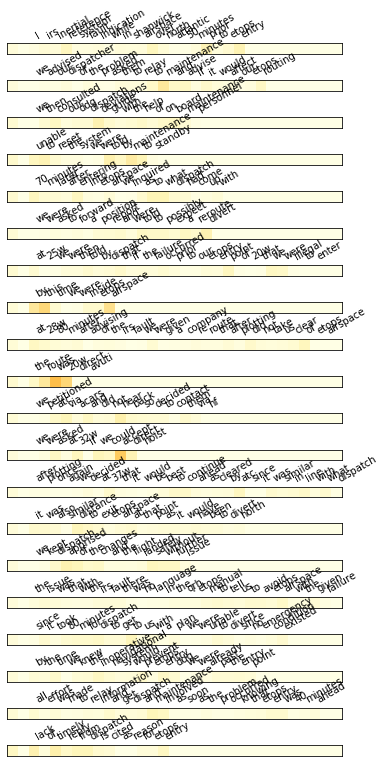

In [113]:
i = 265 #274
description = X_ASRS_tst[i]
sentence = Y_ASRS_tst[i]

ResponseEvaluation(converter_ASRS, description, sentence)

### Naked Base Converter

In [529]:
NBConverter = NakedBaseConverter(lang_glove, 
                                 embedding_dim = 300, 
                                 pre_entrainement = ind2vec_glove, 
                                 freeze = True, 
                                 softmax = True)

In [336]:
def cleanPrintSentence(sentence) :
    return ' '.join(sentence)

In [326]:
i = 33
description = X_ASRS_tst[i]
sentence = Y_ASRS_tst[i]

Sentence  : 

 c172 instructor experienced power loss rough running engine 600 feet agl departure student flying


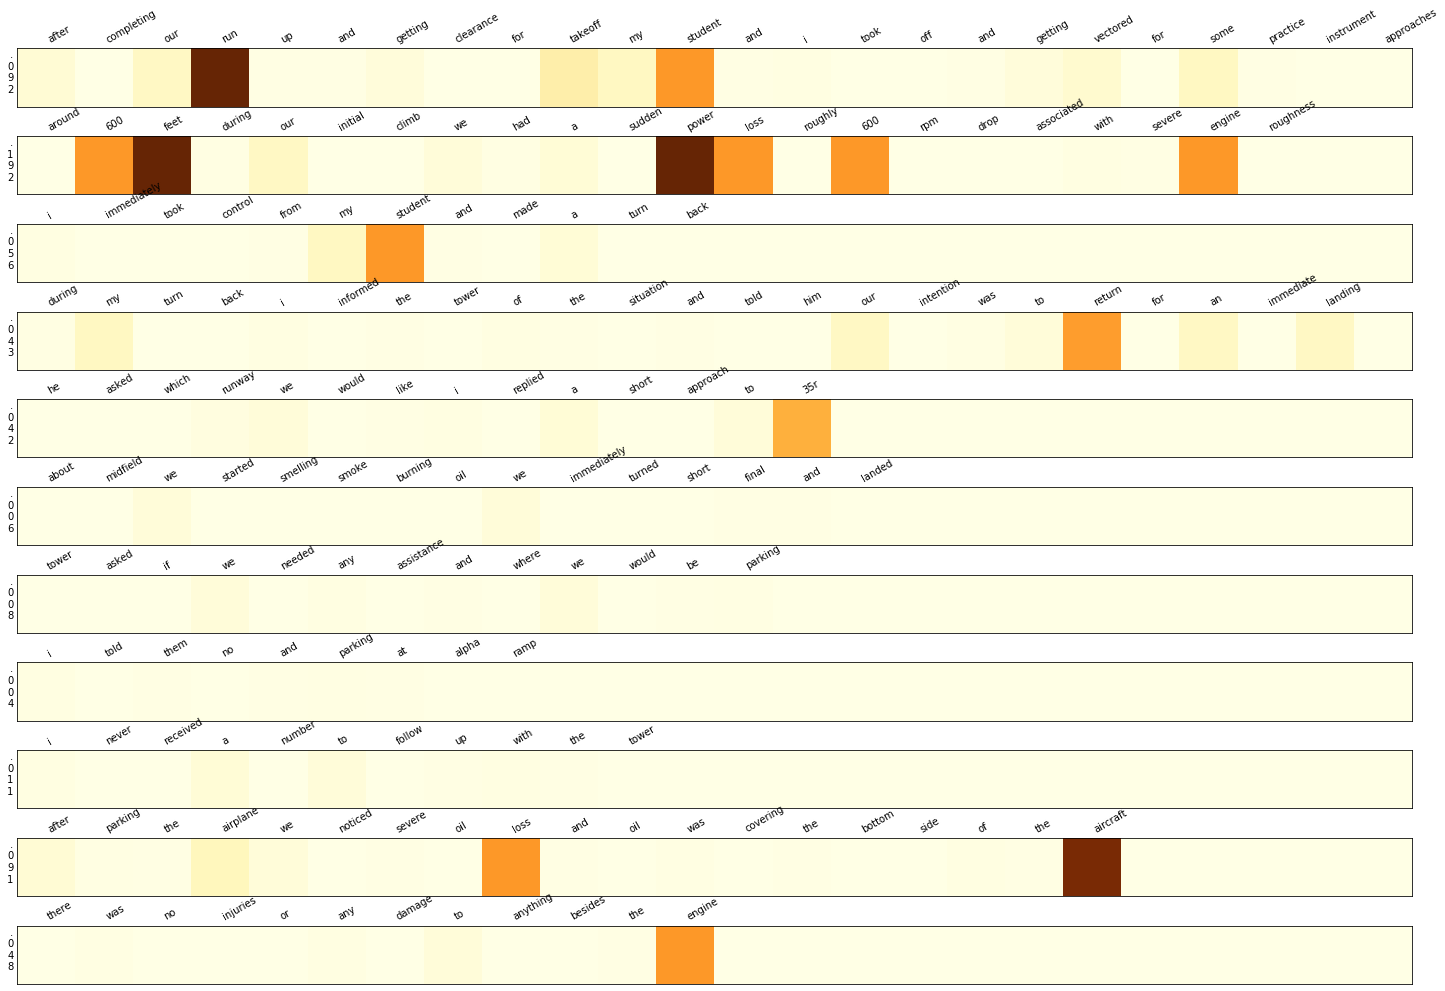

In [508]:
print('Sentence  : \n\n',cleanPrintSentence(sentence))
NBConverter.showConvertion(description, sentence, maxi = 1)

In [530]:
print('Sentence  : \n\n',cleanPrintSentence(sentence))
print('\n')
NBConverter.showSelection(description, sentence) #, percentage = 40)

Sentence  : 

 c172 instructor experienced power loss rough running engine 600 feet agl departure student flying


after completing our run up and getting clearance for takeoff my student and i took off and getting vectored for some practice instrument approaches
around 600 feet during our initial climb we had a sudden power loss roughly 600 rpm drop associated with severe engine roughness
i immediately took control from my student and made a turn back
during my turn back i informed the tower of the situation and told him our intention was to return for an immediate landing
he asked which runway we would like i replied a short approach to 35r
about midfield we started smelling smoke burning oil we immediately turned short final and landed
tower asked if we needed any assistance and where we would be parking
i told them no and parking at alpha ramp
i never received a number to follow up with the tower
after parking the airplane we noticed severe oil loss and oil was covering the bottom 